# Exploring Stdpopsim Models

In [1]:
import stdpopsim
species = stdpopsim.get_species("HomSap")

I want to add my own demographic model using demesgraph. First let's do it for the neutral case

In [2]:
NA = 10000
N1 = 5000
N2 = 5000
T = 2000
M12 = 1e-3
M21 = 1e-5

model1 = stdpopsim.IsolationWithMigration(NA, N1, N2, T, M12, M21)


In [12]:
model1.populations

[Population(initial_size=5000, growth_rate=0, name='pop1', description='', extra_metadata={}, default_sampling_time=None, initially_active=None, id=0),
 Population(initial_size=5000, growth_rate=0, name='pop2', description='', extra_metadata={}, default_sampling_time=None, initially_active=None, id=1),
 Population(initial_size=10000, growth_rate=0, name='ancestral', description='', extra_metadata={}, default_sampling_time=2000, initially_active=False, id=2)]

In [3]:
contig = species.get_contig(length=1e6)
print(contig.recombination_map.sequence_length)
# 1000000.0
print(contig.recombination_map.mean_rate)
# 1.2820402396300886e-08
print(contig.mutation_rate)
# 1.29e-8

1000000.0
1.2820402396300886e-08
1.29e-08


In [5]:
dfe = species.get_dfe("Gamma_K17")  # built-in DFE from Kim et al. (2017)


In [6]:
dfe

DFE(id='Gamma_K17', description='Deleterious Gamma DFE', long_description="\n    Deleterious, gamma-distributed DFE estimated using 'Fit∂a∂i' from the nonsynonymous\n    SFS in exons from a dataset of European humans by Kim et al. (2017).\n    ", mutation_types=[MutationType(dominance_coeff=0.5, distribution_type='f', distribution_args=[0], convert_to_substitution=True, dominance_coeff_list=None, dominance_coeff_breaks=None), MutationType(dominance_coeff=0.5, distribution_type='g', distribution_args=[-0.013148327678138633, 0.186], convert_to_substitution=True, dominance_coeff_list=None, dominance_coeff_breaks=None)], proportions=[0.3, 0.7], citations=[Citation(doi='https://doi.org/10.1534/genetics.116.197145', author='Kim et al.', year=2017, reasons={'distribution of fitness effects'})], qc_dfe=DFE(id='Kim2017_gamma_dfe', description='Kim2017_gamma_dfe', long_description='Kim2017_gamma_dfe', mutation_types=[MutationType(dominance_coeff=0.5, distribution_type='f', distribution_args=[0],

## Neutral Case

In [34]:
import demes
import msprime
import stdpopsim as sps

def im_graph(NA, N1, N2, T, M12, M21, anc="ANC", p1="YRI", p2="CEU"):
    b = demes.Builder()
    b.add_deme(anc, epochs=[dict(start_size=NA, end_time=T)])
    b.add_deme(p1, ancestors=[anc], epochs=[dict(start_size=N1)])
    b.add_deme(p2, ancestors=[anc], epochs=[dict(start_size=N2)])
    if M12 > 0: b.add_migration(source=p1, dest=p2, rate=M12)
    if M21 > 0: b.add_migration(source=p2, dest=p1, rate=M21)
    return b.resolve()

# ---- Your demography (generations ago) ----
NA, N1, N2, T = 10_000, 5_000, 5_000, 2_000
M12, M21 = 1e-3, 1e-5
g = im_graph(NA, N1, N2, T, M12, M21, p1="YRI", p2="CEU")
demog = msprime.Demography.from_demes(g)

# ---- Real human chromosome window (recomb map + μ from stdpopsim) ----
sp = sps.get_species("HomSap")
# 1 Mb window on chr19 (adjust left/right as you like)
contig = sp.get_contig(chromosome="chr21", left=0, right=1e6)

# ---- Neutral simulation ----
samples = {"YRI": 10, "CEU": 10}
ts_neutral = msprime.sim_ancestry(
    samples=samples,
    demography=demog,
    recombination_rate=contig.recombination_map,            # empirical human map for that window
    sequence_length=contig.recombination_map.sequence_length,
    random_seed=42,
)
ts_neutral = msprime.sim_mutations(ts_neutral, rate=contig.mutation_rate, random_seed=42)

print("seq len:", ts_neutral.sequence_length)
print("mean r:", contig.recombination_map.mean_rate)
print("mu:", contig.mutation_rate)
print("#sites:", ts_neutral.num_sites)


seq len: 46709983.0
mean r: 1.724434082825555e-08
mu: 1.29e-08
#sites: 1983


Text(0, 0.5, 'N')

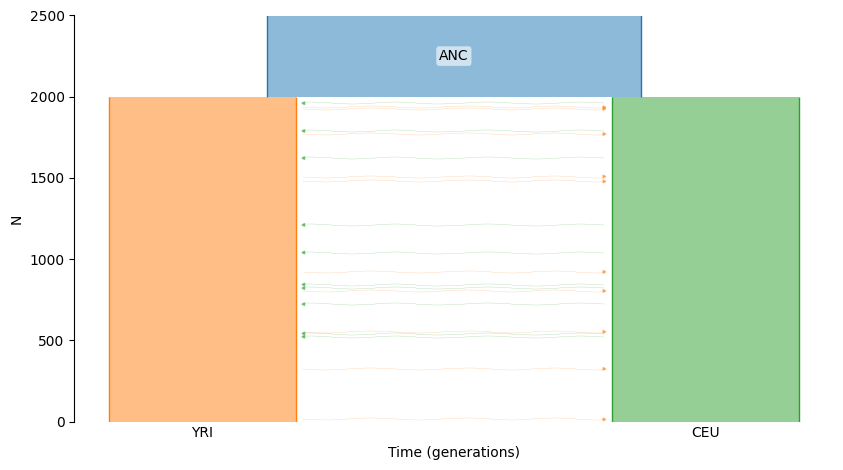

In [35]:
import demesdraw

ax = demesdraw.tubes(g) #TODO: Change from bottleneck model to the model_type
ax.set_xlabel("Time (generations)")
ax.set_ylabel("N")

## Background Selection (BGS) Case

In [2]:
from stdpopsim import DemographicModel

In [3]:
class IsolationWithMigration(DemographicModel):
    """
    Class representing a generic simulation model that can be run to output a tree
    sequence. A generic isolation with migration model where a single ancestral
    population of size NA splits into two populations of constant size N1
    and N2 time T generations ago, with migration rates M12 and M21 between
    the split populations. Sampling is disallowed in population index 0,
    as this is the ancestral population.

    :param float NA: The initial ancestral effective population size
    :param float N1: The effective population size of population 1
    :param float N2: The effective population size of population 2
    :param float T: Time of split between populations 1 and 2 (in generations)
    :param float M12: Migration rate from population 1 to 2
    :param float M21: Migration rate from population 2 to 1

    Example usage:

    .. code-block:: python

        model1 = stdpopsim.IsolationWithMigration(NA, N1, N2, T, M12, M21)

    """

    def __init__(self, NA, N1, N2, T, M12, M21):
        model = msprime.Demography()
        model.add_population(initial_size=N1, name="YRI")
        model.add_population(initial_size=N2, name="CEU")
        model.add_population(initial_size=NA, name="ANC")

        # FIXME This is BACKWARDS in time, so the rates are the other
        # way around forwards time. We should explain this in the documentation
        # (and probably swap around). Seems like there's not really much
        # good reason to have this model in here any more though - what
        # does it do that wouldn't be better done in demes/msprime?
        model.set_migration_rate(source="YRI", dest="CEU", rate=M12)
        model.set_migration_rate(source="CEU", dest="YRI", rate=M21)
        model.add_population_split(
            time=T, ancestral="ANC", derived=["YRI", "CEU"]
        )
        long_description = """
            A generic isolation with migration model where a single ancestral
            population of size NA splits into two populations of constant size N1
            and N2 time T generations ago, with migration rates M12 and M21 between
            the split populations.
            """
        super().__init__(
            id="IsolationWithMigration",
            description="Generic IM model",
            long_description=long_description,
            model=model,
            generation_time=1,
        )


In [27]:
import numpy as np
import demes
import msprime
import stdpopsim as sps

def im_graph(NA, N1, N2, T, M12, M21, anc="ANC", p1="YRI", p2="CEU"):
    b = demes.Builder()
    b.add_deme(anc, epochs=[dict(start_size=NA, end_time=T)])
    b.add_deme(p1, ancestors=[anc], epochs=[dict(start_size=N1)])
    b.add_deme(p2, ancestors=[anc], epochs=[dict(start_size=N2)])
    if M12 > 0: b.add_migration(source=p1, dest=p2, rate=M12)
    if M21 > 0: b.add_migration(source=p2, dest=p1, rate=M21)
    return b.resolve()

# ---- Your demography (generations ago) ----
NA, N1, N2, T = 10_000, 5_000, 5_000, 2_000
M12, M21 = 1e-3, 1e-5
g = im_graph(NA, N1, N2, T, M12, M21, p1="YRI", p2="CEU")
demog = msprime.Demography.from_demes(g)

# ---- Real human chromosome window (recomb map + μ from stdpopsim) ----
sp = sps.get_species("HomSap")
# 1 Mb window on chr19 (adjust left/right as you like)
contig = sp.get_contig(chromosome="chr21", left=0, right=1e6)

# ---- Neutral simulation ----
samples = {"YRI": 10, "CEU": 10}

contig.add_dfe(intervals=np.array([[0, int(contig.length)]]), DFE=dfe)

In [28]:
custom_model = IsolationWithMigration(NA, N1, N2, T, M12, M21)

In [29]:
engine = stdpopsim.get_engine("slim")
ts = engine.simulate(
    custom_model,
    contig,
    samples,
    seed=123,
    slim_scaling_factor=10,
    slim_burn_in=10,
)

/home/akapoor/.local/lib/python3.10/site-packages/stdpopsim/slim_engine.py:1636: SLiMScalingFactorWarning: You're using a scaling factor (10). This should give similar results for many situations, but is not equivalent, especially in the presence of selection. When using rescaling, you should be careful---do checks and compare results across different values of the scaling factor.
  warnings.warn(


In [31]:
import moments

sample_sets = [
    ts.samples(population=pop.id) 
    for pop in ts.populations() 
    if len(ts.samples(population=pop.id)) > 0  # Exclude populations with no samples
]


sfs = ts.allele_frequency_spectrum(
    sample_sets=sample_sets,
    mode="site",
    polarised=True,
    span_normalise=False  # <-- crucial
)

# Convert to 1D or 2D moments Spectrum
sfs = moments.Spectrum(sfs)

# Get the population names from the TreeSequence
pop_names = [
    pop.metadata.get("name", f"pop{pop.id}")
    for pop in ts.populations()           # iterate, no arguments
]

# I don't want the ancestral size in the pop names
if len(pop_names) > 1 and pop_names[0] == "N0":
    pop_names = pop_names[1:]  # Remove the ancestral population name

# if ts.num_populations == 1:
#     pop_names = [ts.populations(0).metadata.get("name", "N0")]
# else:
#     pop_names = ["N1", "N2"]

sfs.pop_ids = pop_names


In [ ]:
# Run moments inference using snakemake_scripts/moments_dadi_inference.py logic
import sys
from pathlib import Path
sys.path.insert(0, str(Path('../src').resolve()))
import moments_inference
import pickle, json

# --- Set paths to your files ---
sfs_file = Path("experiments/split_isolation/simulations/0/SFS.pkl")  # update as needed
config_file = Path("config_files/experiment_config_split_isolation.json")

# --- Load SFS and config ---
with open(sfs_file, "rb") as f:
    sfs = pickle.load(f)
with open(config_file) as f:
    config = json.load(f)

# --- Import your demography builder ---
from src.simulation import split_isolation_model
model_func = split_isolation_model

# --- Prepare starting parameters ---
priors = config["priors"]
start_dict = {k: (v[0] + v[1]) / 2 for k, v in priors.items()}

# --- Run moments inference ---
result = moments_inference.fit_model(
    sfs=sfs,
    start_dict=start_dict,
    demo_model=model_func,
    experiment_config=config,
    fixed_params={}
)
print("Best-fit parameters:", result[0])
print("Log-likelihood:", result[1])